# Personal Information
Name: **Florian Andrei Maria**

StudentID: **15251616**

Email: [**andrei.maria@student.uva.nl**]
Github: (https://github.com/Andreihbk/Master-EDA)

Submitted on: *28.03.2025**


# Data Context

In this thesis project, we work with a dataset provided by SICK AG, focusing on **industrial bin metadata**. The data is made available in **RDF/Turtle (`.ttl`) files**, meaning it is structured as a knowledge graph rather than a typical numeric or tabular dataset. 

Additionally, we have a “synthetic sample” which mirrors the structure of the real SICK Bins data, but with certain information removed or anonymized. The primary goal is to explore how this graph-based metadata can inform a **distance measure** for recommending or reusing industrial bin information across different contexts.

This EDA will concentrate on:
- **Inspecting the `.ttl` files** (sample, taxonomy, alignment, etc.).
- **Mapping the relationships** (hierarchies, external ontology alignments).
- **Preparing for a graph-based similarity measure** (since numeric data is minimal).


# Data Description

In this section, we explore the SICK Bins dataset in its RDF/Turtle format. The analysis focused on **graph-centric** properties rather than numeric features, because most of the dataset consists of relationships (triples) and semantic metadata.

## Overview
- **Files analyzed**:
  1. **sickbins-sample.ttl**: A synthetic sample with anonymized or removed sensor data.
  2. **sickbins.ttl**: The so-called “full” dataset, though it has fewer triples than the sample.
  3. **sickbins-taxonomy.ttl**: Defines categories, mostly using SKOS predicates like `skos:hasTopConcept`.
  4. **alignment.ttl**: Contains ontology mappings (e.g., `owl:equivalentClass`) to external vocabularies like SOSA/SSN.

### Key Findings
1. **Triple Counts & Unique Predicates**  
   - `sickbins-sample.ttl` had **440 triples**, `sickbins.ttl` had **198 triples**.  
   - **Unique predicates** ranged from 35 (sample) down to 20-ish in the other files.  

2. **Minimal Numeric Attributes**  
   - Most properties are strings or references to URIs.  
   - Very few numeric fields (e.g., `objectHeight`, `objectWidth`) appear inconsistently.  

3. **Shallow Hierarchy**  
   - We checked `rdfs:subClassOf`, `skos:broader`, and `skos:hasTopConcept` and found only **a handful of class relationships** (e.g., `Image → Artifact`, `Reading → sosa:Result`).  

4. **Ontology Alignment**  
   - `alignment.ttl` links some classes to external ontologies (e.g., `sosa:Sensor`), but the depth of those links is limited.

### Observations & Decisions
- Because there are **few numeric features**, traditional EDA (mean, median, standard deviation) is not very informative.
- The data’s **key value** is in its **relationships**—which led us to use **graph-based analysis**.

## Next Steps
- **Graph Embedding Approach** (node2vec) to measure similarity among entities in the knowledge graph.
- **Baseline** for similarity could be a naive method (e.g., shared predicates) to compare against node2vec results.



In [ ]:
#pip install pyyaml pandas rdflib matplotlib seaborn networkx


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from rdflib import Graph, URIRef
import networkx as nx
import matplotlib.pyplot as plt
import json



### Data Loading

In [ ]:
# Define file paths
stammdata_map_path = "stammdata_map.json"
stammdata_schema_path = "stammdata_schema.json"

# Load the JSON files
def load_json(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)


# Specify your TTL files
ttl_files = {
    "sample": "sickbins-sample.ttl",  # Use this first for quick tests
    "full": "sickbins.ttl",            # Main dataset
    "taxonomy": "sickbins-taxonomy.ttl", # Taxonomy relationships
    "alignment": "alignment.ttl"
}

# Function to load a TTL file
def load_graph(ttl_path):
    g = Graph()
    g.parse(ttl_path, format="turtle")
    print(f" Loaded {ttl_path}: {len(g)} triples found.")
    return g


print("Data loading functions defined.")

Data loading functions defined.




**Explanation :**
- **We import** `json`, `rdflib`, `networkx`, and `matplotlib` to **handle** JSON structures, RDF graphs, and any graph visualization.
- **`load_json(file_path)`**: A helper function to cleanly read JSON files.
- **`ttl_files`**: A dictionary pointing to each `.ttl` file we’ll need.
- **`load_graph(ttl_path)`**: Loads a TTL file and prints the number of triples found.

---


### **Analysis 1: Inspect `stammdata_map.json` and `stammdata_schema.json`**


**Explanation:**
- **Step 1**: We call our loading function to retrieve both JSON objects.  
- **Step 2**: We **inspect the keys** to understand what structure they contain.  
- **Step 3**: Print partial content for a **quick glance**—useful for debugging or verifying the data format.

In [ ]:

# 1. Load the JSON files
stammdata_map = load_json(stammdata_map_path)
stammdata_schema = load_json(stammdata_schema_path)

# 2. Print basic info
print("Keys in stammdata_map.json:", stammdata_map.keys())
print("Keys in stammdata_schema.json:", stammdata_schema.keys())

# 3. Show partial content to get a sense of what's inside
print("\nSample from stammdata_map.json:")
for k, v in list(stammdata_map.items())[:5]:  # first 5 items
    print(f"  {k}: {v}")

print("\nSample from stammdata_schema.json:")
for k in list(stammdata_schema.keys())[:3]:  # first 3 keys
    print(f"  {k}: {stammdata_schema[k]}")


Keys in stammdata_map.json: dict_keys(['Behaeltertyp', 'Breite', 'Code', 'Count_of_EW_0WM_WT', 'EWP_Confirmed_Time', 'EWP_Quittierzeit_Lageraufgabe', 'Gewichtseinheit', 'HU_Nummer', 'Hoehe', 'Laenge', 'Masseinheit', 'Materialnummer', 'Materialtext', 'Menge', 'Mengeneinheit', 'Nettogewicht', 'Timestamp', 'Timestamp_formatiert', 'Volumen', 'Volumeneinheit', 'uuid'])
Keys in stammdata_schema.json: dict_keys(['$schema', 'type', 'properties', 'required'])

Sample from stammdata_map.json:
  Behaeltertyp: binType
  Breite: objectWidth
  Code: code
  Count_of_EW_0WM_WT: ewCount
  EWP_Confirmed_Time: ewConfirmedTime

Sample from stammdata_schema.json:
  $schema: http://json-schema.org/draft-07/schema#
  type: object
  properties: {'Behaeltertyp': {'type': 'string'}, 'Breite': {'type': 'integer'}, 'Code': {'type': 'string'}, 'Count_of_EW_0WM_WT': {'type': 'null'}, 'EWP_Confirmed_Time': {'type': 'integer'}, 'EWP_Quittierzeit_Lageraufgabe': {'type': 'string'}, 'Gewichtseinheit': {'type': 'string'}


## **Analysis 2: Loading & Inspecting `.ttl` Files**

1. **Load Each TTL File**  
2. **Extract Basic Statistics** (e.g., total triples, unique subjects/predicates/objects)  
3. **Print a Few Sample Triples**  




In [ ]:

# 1. Load each TTL file and store in a dictionary
graphs = {}
for key, path in ttl_files.items():
    g = load_graph(path)
    graphs[key] = g

# 2. Print basic stats for each graph
for key, g in graphs.items():
    print(f"\n=== Stats for '{key}' graph ===")
    
    # Count total triples
    num_triples = len(g)
    print(f"Total triples: {num_triples}")
    
    # Extract unique subjects, predicates, and objects
    subjects = set(g.subjects())
    predicates = set(g.predicates())
    objects = set(g.objects())
    
    print(f"Unique subjects: {len(subjects)}")
    print(f"Unique predicates: {len(predicates)}")
    print(f"Unique objects: {len(objects)}")
    
    # Print sample of 5 triples
    print("\nSample Triples:")
    sample_triples = list(g)[:5]
    for s, p, o in sample_triples:
        print(f"  {s} --[{p}]--> {o}")



 Loaded sickbins-sample.ttl: 440 triples found.
 Loaded sickbins.ttl: 198 triples found.
 Loaded sickbins-taxonomy.ttl: 176 triples found.
 Loaded alignment.ttl: 103 triples found.

=== Stats for 'sample' graph ===
Total triples: 440
Unique subjects: 86
Unique predicates: 35
Unique objects: 197

Sample Triples:
  https://data.sick.com/res/sickbins/91c9f1f7-d536-42ff-b1dd-232f81084f04 --[https://data.sick.com/voc/sam/core/artifact-model/hasArtifact]--> https://data.sick.com/res/sickbins/29150e3f-1ab5-4795-9ac4-15ee4060165c
  https://data.sick.com/res/sickbins/38705c52-b92b-4de7-9c22-e3348a3fbd6e --[http://www.w3.org/1999/02/22-rdf-syntax-ns#type]--> http://www.w3.org/2002/07/owl#NamedIndividual
  https://data.sick.com/res/sickbins/97a1553d-3ac4-46c0-94ae-d3cfc248504a --[https://data.sick.com/voc/sam/core-model/consistsOf]--> https://data.sick.com/res/sickbins/9297235e-36ee-431d-9c19-fc3499e15624
  https://data.sick.com/res/sickbins/992518f7-f326-488a-95f5-cbb5ce773301 --[https://data.si

### Analysis 3:  Taxonomy  Inspection

In [ ]:
# Analysis 3

# We'll focus on the 'taxonomy' graph
taxonomy_graph = graphs["taxonomy"]

print("\n=== Taxonomy Inspection ===")

# 1. Extract predicates to see if we have skos:broader / skos:hasTopConcept
taxonomy_predicates = set(taxonomy_graph.predicates())
print("Unique Predicates in the Taxonomy Graph:")
for pred in taxonomy_predicates:
    print(" ", pred)

# 2. Check for specific taxonomy predicates (skos:broader, skos:hasTopConcept)
from rdflib import URIRef

skos_broader = URIRef("http://www.w3.org/2004/02/skos/core#broader")
skos_topConcept = URIRef("http://www.w3.org/2004/02/skos/core#hasTopConcept")

broader_triples = list(taxonomy_graph.triples((None, skos_broader, None)))
topconcept_triples = list(taxonomy_graph.triples((None, skos_topConcept, None)))

print(f"\nFound {len(broader_triples)} skos:broader relationships.")
print(f"Found {len(topconcept_triples)} skos:hasTopConcept relationships.")

# Print a few examples
if broader_triples:
    print("\nSample skos:broader triples:")
    for s, p, o in broader_triples[:5]:
        print(f"  {s} --[{p}]--> {o}")

if topconcept_triples:
    print("\nSample skos:hasTopConcept triples:")
    for s, p, o in topconcept_triples[:5]:
        print(f"  {s} --[{p}]--> {o}")



=== Taxonomy Inspection ===
Unique Predicates in the Taxonomy Graph:
  http://purl.org/dc/terms/rights
  http://www.w3.org/2004/02/skos/core#broarder
  http://www.w3.org/2004/02/skos/core#changeNote
  http://www.w3.org/2004/02/skos/core#prefLabel
  http://www.w3.org/2004/02/skos/core#topConceptOf
  http://purl.org/dc/terms/description
  http://www.w3.org/2002/07/owl#versionIRI
  http://www.w3.org/2000/01/rdf-schema#isDefinedBy
  http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  http://www.w3.org/2004/02/skos/core#hasTopConcept
  http://www.w3.org/2000/01/rdf-schema#label
  https://data.sick.com/voc/ccr/life-cycle-model/hasState
  http://www.w3.org/2004/02/skos/core#definition
  http://purl.org/dc/terms/modified
  http://www.w3.org/2002/07/owl#versionInfo
  http://www.w3.org/2004/02/skos/core#inScheme
  http://purl.org/dc/terms/creator
  http://purl.org/vocab/vann/preferredNamespacePrefix
  http://purl.org/vocab/vann/preferredNamespaceUri
  http://purl.org/dc/terms/issued

Found 0 skos

### Analysis 4:  Alignment Inspection

In [ ]:
# Analysis 4: Alignment Inspection

# We'll focus on the 'alignment' graph
alignment_graph = graphs["alignment"]

print("\n=== Alignment Inspection ===")

# 1. List all unique predicates in alignment.ttl
alignment_predicates = set(alignment_graph.predicates())
print("Unique Predicates in Alignment Graph:")
for pred in alignment_predicates:
    print(" ", pred)

# 2. Check typical alignment predicates
from rdflib import URIRef

owl_sameAs = URIRef("http://www.w3.org/2002/07/owl#sameAs")
owl_equivalentClass = URIRef("http://www.w3.org/2002/07/owl#equivalentClass")
skos_exactMatch = URIRef("http://www.w3.org/2004/02/skos/core#exactMatch")

alignment_triples = {
    "sameAs": list(alignment_graph.triples((None, owl_sameAs, None))),
    "equivalentClass": list(alignment_graph.triples((None, owl_equivalentClass, None))),
    "exactMatch": list(alignment_graph.triples((None, skos_exactMatch, None)))
}

for key, triple_list in alignment_triples.items():
    print(f"\nFound {len(triple_list)} `{key}` relationships.")
    if triple_list:
        print(f"Sample for {key}:")
        for s, p, o in triple_list[:3]:
            print(f"  {s} --[{p}]--> {o}")



=== Alignment Inspection ===
Unique Predicates in Alignment Graph:
  http://purl.org/dc/terms/rights
  http://www.w3.org/2004/02/skos/core#changeNote
  http://www.w3.org/2004/02/skos/core#prefLabel
  http://www.w3.org/1999/02/22-rdf-syntax-ns#first
  http://purl.org/dc/terms/description
  http://www.w3.org/2000/01/rdf-schema#subPropertyOf
  http://www.w3.org/2002/07/owl#versionIRI
  http://www.w3.org/2000/01/rdf-schema#isDefinedBy
  http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  http://www.w3.org/2002/07/owl#unionOf
  http://www.w3.org/2002/07/owl#onProperty
  http://www.w3.org/2002/07/owl#equivalentClass
  http://www.w3.org/2000/01/rdf-schema#subClassOf
  http://www.w3.org/2000/01/rdf-schema#label
  http://www.w3.org/2004/02/skos/core#definition
  http://purl.org/dc/terms/modified
  http://www.w3.org/2002/07/owl#versionInfo
  http://www.w3.org/1999/02/22-rdf-syntax-ns#rest
  http://www.w3.org/2002/07/owl#someValuesFrom
  http://purl.org/vocab/vann/preferredNamespacePrefix
  http:/

### Analysis 5: Graph Visualization


=== Graph Visualization for `sickbins-sample.ttl` ===
Number of nodes: 203
Number of edges: 440


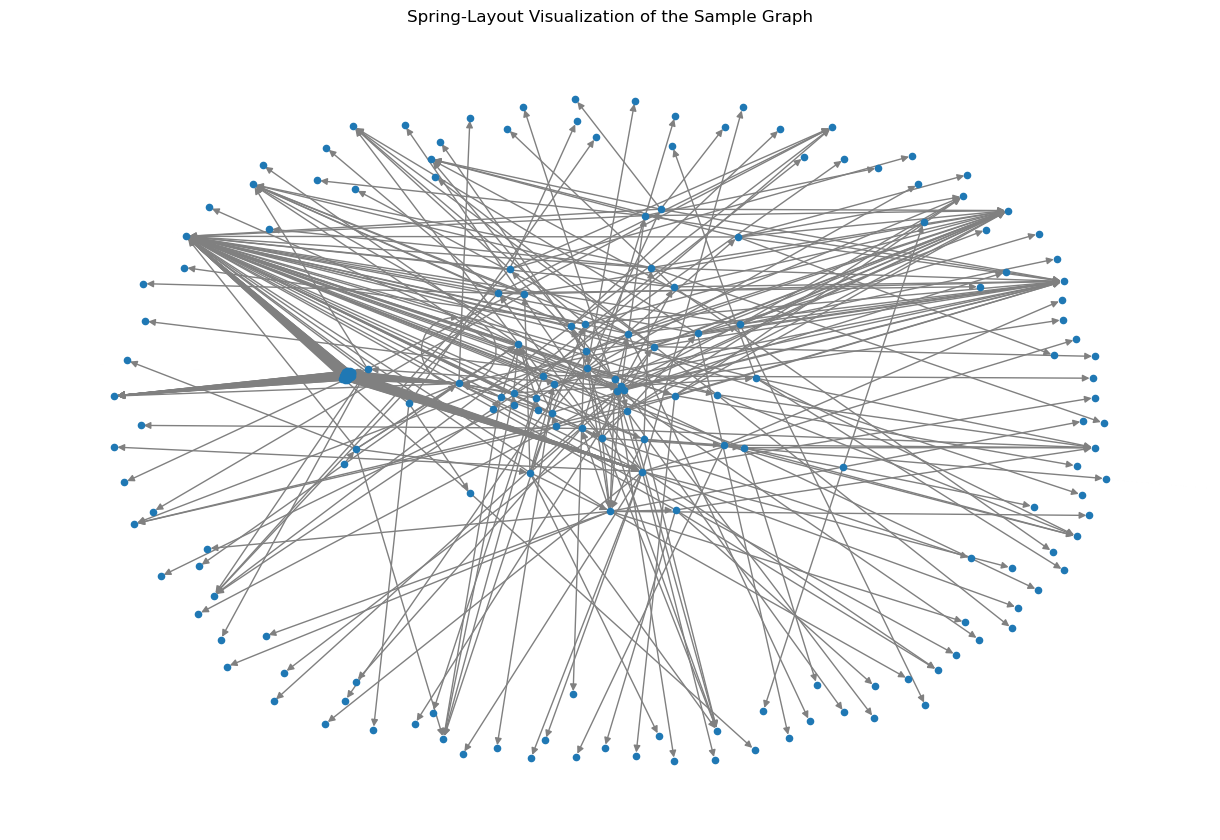

In [ ]:
# Analysis 5: Graph Visualization

# We'll visualize the 'sample' graph
sample_graph = graphs["sample"]

print("\n=== Graph Visualization for `sickbins-sample.ttl` ===")

# Convert RDF graph to a NetworkX directed graph
nx_sample = nx.DiGraph()
for s, p, o in sample_graph:
    nx_sample.add_edge(str(s), str(o), label=str(p))

print(f"Number of nodes: {nx_sample.number_of_nodes()}")
print(f"Number of edges: {nx_sample.number_of_edges()}")

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(nx_sample, seed=42)
nx.draw(
    nx_sample, pos,
    node_size=20,        # smaller node size for better visibility
    edge_color="gray",
    with_labels=False    # turn off labels to avoid clutter
)
plt.title("Spring-Layout Visualization of the Sample Graph")
plt.show()
